In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydotplus
import seaborn as sns
import sklearn
import sys

from copy import deepcopy
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

RESULTS_PATH = os.path.join('./results')


# Getting the data & setup


In [2]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
# we probably wont use this until we know how to neural network
audio_df = pd.read_csv(DATA_PATH + 'audio_data.csv')
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')


In [3]:
song_dropped_df = song_dropped_df.drop(
    columns=['artist_name', 'track_name'])
song_filled_df = song_filled_df.drop(columns=['artist_name', 'track_name'])


In [4]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i += 1

modes = dict({song_filled_df['mode'].unique()[0]: 0,
             song_filled_df['mode'].unique()[1]: 1})

song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])


In [5]:
# getting a list of all genre names
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

# getting a list of all features in each data frame
audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')


In [6]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']


creating the initial splits


In [95]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20, shuffle = True, stratify = y_audio)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30, shuffle = True, stratify = y_dropped)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30, shuffle = True, stratify = y_filled)


Separating data from labels


In [96]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))


1000
40560
50000


Some methods do not work with the string labels, so we mapped the genre titles for each data set to unique integers


In [97]:
y_audio_nums = y_audio.copy()
y_audio_nums.replace(audio_genres, [x for x in range(10)], inplace=True)

y_dropped_nums = y_dropped.copy()
y_dropped_nums.replace(dropped_genres, [x for x in range(10)], inplace=True)

y_filled_nums = y_filled.copy()
y_filled_nums.replace(filled_genres, [x for x in range(10)], inplace=True)


# Modeling


## Prepararation


In [10]:
audio_results_metrics = pd.DataFrame()
dropped_results_metrics = pd.DataFrame()
filled_results_metrics = pd.DataFrame()


In [11]:
# parameters:   pipe - model pipeline
#               params - dictionary of parameters specific to the model
#               X,y - X and y for the data set that should be used for cross validating
#               label - label of the data set
def run_grid_search(pipe, params, X, y, label, cv=None, n_jobs=-1):
    clf_GSCV = GridSearchCV(pipe, params, cv=cv)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

In [12]:
# defining the scaler we will be using
sc = StandardScaler()


## Clustering

In [13]:
from sklearn import metrics
from sklearn.cluster import KMeans

def cluster(X):
    scores = []
    score_max = -1
    k_best = 0

    k_values = np.arange(2, 10)

    # k is the number of clusters
    # iterate through a range of k values and find the best
    for k in k_values:
        # Train the model
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit(X)
        
        # extract performance metrics
        score = metrics.silhouette_score(X, kmeans.labels_, 
                    metric='euclidean', sample_size=len(X))

        print('\n k = {:} --> Silhouette score = {:.4f}'.format(k, score))
                        
        scores.append(score)
        if score > score_max:
            score_max = score
            k_best = k
            
            
    # Best params
    print('\nBest k = {:} --> silhouette score: {:.4f}'.format(k_best, score_max))


In [14]:
print("Clusters for audio dataset")
cluster(X_audio_train)

Clusters for audio dataset

 k = 2 --> Silhouette score = 0.3695

 k = 3 --> Silhouette score = 0.2668

 k = 4 --> Silhouette score = 0.2705

 k = 5 --> Silhouette score = 0.2366

 k = 6 --> Silhouette score = 0.2342

 k = 7 --> Silhouette score = 0.2264

 k = 8 --> Silhouette score = 0.2128

 k = 9 --> Silhouette score = 0.2133

Best k = 2 --> silhouette score: 0.3695


In [15]:
print("Clusters for dropped dataset")
cluster(X_dropped_train)

Clusters for dropped dataset

 k = 2 --> Silhouette score = 0.5950

 k = 3 --> Silhouette score = 0.5111

 k = 4 --> Silhouette score = 0.4586

 k = 5 --> Silhouette score = 0.4088

 k = 6 --> Silhouette score = 0.3575

 k = 7 --> Silhouette score = 0.3055

 k = 8 --> Silhouette score = 0.2940

 k = 9 --> Silhouette score = 0.2972

Best k = 2 --> silhouette score: 0.5950


In [16]:
print("Clusters for filled dataset")
cluster(X_filled_train)

Clusters for filled dataset

 k = 2 --> Silhouette score = 0.5958

 k = 3 --> Silhouette score = 0.5120

 k = 4 --> Silhouette score = 0.4571

 k = 5 --> Silhouette score = 0.4088

 k = 6 --> Silhouette score = 0.3574

 k = 7 --> Silhouette score = 0.3148

 k = 8 --> Silhouette score = 0.3006

 k = 9 --> Silhouette score = 0.2593

Best k = 2 --> silhouette score: 0.5958


In [17]:
from itertools import cycle
from sklearn.cluster import DBSCAN
from sklearn import metrics

def eps_cluster(X):
    # Find the best epsilon
    eps_grid = np.linspace(0.3, 1.2, num=10)

    silhouette_scores = []
    eps_best = eps_grid[0]

    silhouette_score_max = -1
    model_best = None
    labels_best = None

    # finding the best epsilon
    for eps in eps_grid:
        # Train DBSCAN clustering model
        model = DBSCAN(eps=eps, min_samples=5).fit(X)

        if not all(model.labels_ == 0):
            # extract performance metric 
            silhouette_score = round(metrics.silhouette_score(X, model.labels_), 4)
            silhouette_scores.append(silhouette_score)

            print("Epsilon: {:.4f} --> silhouette score: {:.4f}".format(eps, silhouette_score))

            if silhouette_score > silhouette_score_max:
                silhouette_score_max = silhouette_score
                eps_best = eps
                model_best = model
                labels_best = model.labels_
        
    # Best params
    print('\nBest epsilon = {:.4f}'.format(eps_best))

    # Check for unassigned datapoints in the labels
    offset = 0
    if -1 in labels_best:
        offset = 1

    # Number of clusters in the data 
    num_clusters = len(set(labels_best)) - offset 

    print("\nEstimated number of clusters =", num_clusters)

In [18]:
print("DBSCAN Clusters for audio dataset")
eps_cluster(X_audio_train)

DBSCAN Clusters for audio dataset
Epsilon: 0.3000 --> silhouette score: 0.4412

Best epsilon = 0.3000

Estimated number of clusters = 1


In [19]:
print("DBSCAN Clusters for dropped dataset")
eps_cluster(X_dropped_train)

DBSCAN Clusters for dropped dataset
Epsilon: 0.3000 --> silhouette score: -0.0284
Epsilon: 0.4000 --> silhouette score: 0.2274
Epsilon: 0.5000 --> silhouette score: 0.3265
Epsilon: 0.6000 --> silhouette score: 0.3366
Epsilon: 0.7000 --> silhouette score: 0.3372
Epsilon: 0.8000 --> silhouette score: 0.3375
Epsilon: 0.9000 --> silhouette score: 0.3351
Epsilon: 1.0000 --> silhouette score: 0.3376

Best epsilon = 1.0000

Estimated number of clusters = 24


In [20]:
print("DBSCAN Clusters for filled dataset")
eps_cluster(X_filled_train)

DBSCAN Clusters for filled dataset
Epsilon: 0.3000 --> silhouette score: -0.0164
Epsilon: 0.4000 --> silhouette score: 0.2553
Epsilon: 0.5000 --> silhouette score: 0.3212
Epsilon: 0.6000 --> silhouette score: 0.3380
Epsilon: 0.7000 --> silhouette score: 0.3384
Epsilon: 0.8000 --> silhouette score: 0.3386
Epsilon: 0.9000 --> silhouette score: 0.3388
Epsilon: 1.0000 --> silhouette score: 0.3388

Best epsilon = 0.9000

Estimated number of clusters = 24


## Training


### Optimized Random Forest


In [98]:
forest = RandomForestClassifier()

forest_pipe = Pipeline(steps=[('sc', sc),
                              ('forest', forest)])

# n_estimators = [200, 500, 1000]
# # We determined entropy was optimal from the decision tree modeling
# criterion = ['entropy']
# max_depth = [10, None]
# max_features = ['sqrt', 'log2', None]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 3, 5]

n_estimators = [50, 200]
criterion = ['entropy']
max_depth = [10]
max_features = ['sqrt', 'log2']
min_samples_split = [2]
min_samples_leaf = [1, 3]

forest_parameters = dict(forest__n_estimators=n_estimators,
                         forest__criterion=criterion,
                         forest__max_depth=max_depth,
                         forest__max_features=max_features,
                         forest__min_samples_split=min_samples_split,
                         forest__min_samples_leaf=min_samples_leaf)

forest_results_df = pd.DataFrame()
forest_results_df = forest_results_df.append(
    run_grid_search(forest_pipe, forest_parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(forest_pipe, forest_parameters, X_dropped, y_dropped, 'Dropped'))

forest_results_df.reset_index(inplace=True, drop=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_8980\2247176492.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forest_results_df = forest_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_8980\2247176492.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(forest_pipe, forest_parameters, X_audio, y_audio, 'Audio')).append(


In [82]:
best_forest_audio = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                      (forest_results_df.label == 'Audio')]

best_forest_dropped = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                        (forest_results_df.label == 'Dropped')]


In [101]:
print('best audio parameters:\n',
      '--n_estimators--\n',
      best_forest_audio.param_forest__n_estimators.values,
      '\n--criterion--\n',
      best_forest_audio.param_forest__criterion.values,
      '\n--max_depth--\n',
      best_forest_audio.param_forest__max_depth.values,
      '\n--max_features--\n',
      best_forest_audio.param_forest__max_features.values,
      '\n--min_samples_split--\n',
      best_forest_audio.param_forest__min_samples_split.values,
      '\n--min_samples_leaf--\n',
      best_forest_audio.param_forest__min_samples_leaf.values)

print('\n\nbest dropped parameters:\n',
      '--n_estimators--\n',
      best_forest_dropped.param_forest__n_estimators.values,
      '\n--criterion--\n',
      best_forest_dropped.param_forest__criterion.values,
      '\n--max_depth--\n',
      best_forest_dropped.param_forest__max_depth.values,
      '\n--max_features--\n',
      best_forest_dropped.param_forest__max_features.values,
      '\n--min_samples_split--\n',
      best_forest_dropped.param_forest__min_samples_split.values,
      '\n--min_samples_leaf--\n',
      best_forest_dropped.param_forest__min_samples_leaf.values)


best audio parameters:
 --n_estimators--
 [50] 
--criterion--
 ['entropy'] 
--max_depth--
 [10] 
--max_features--
 ['sqrt'] 
--min_samples_split--
 [2] 
--min_samples_leaf--
 [1]


best dropped parameters:
 --n_estimators--
 [200] 
--criterion--
 ['entropy'] 
--max_depth--
 [10] 
--max_features--
 ['log2'] 
--min_samples_split--
 [2] 
--min_samples_leaf--
 [3]


In [116]:
forest_audio = deepcopy(forest_pipe)
forest_audio.set_params(**best_forest_audio.params.values[0])
forest_audio.fit(X_audio_train, y_audio_train)
y_pred_forest_audio = forest_audio.predict(X_audio_test)

forest_dropped = deepcopy(forest_pipe)
forest_dropped.set_params(**best_forest_dropped.params.values[0])
forest_dropped.fit(X_dropped_train, y_dropped_train)
y_pred_forest_dropped = forest_dropped.predict(X_dropped_test)


In [117]:
forest_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_forest_audio, output_dict=True))
forest_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_forest_dropped, output_dict=True))

forest_result_metrics_audio['model_type'] = 'forest'
forest_result_metrics_dropped['model_type'] = 'forest'

print('Accuracy for audio: {:.3f}'.format(
    forest_result_metrics_audio['accuracy'].iloc[0]))
print('Accuracy for dropped: {:.3f}'.format(
    forest_result_metrics_dropped['accuracy'].iloc[0]))


Accuracy for audio: 0.460
Accuracy for dropped: 0.571


## Plotting the Results


#### Result metrics data


In [118]:
def plot_metrics_by_genre(results_df, genres, title='Boxplots for each genre', plot_name=None):
    df = results_df.drop(
        columns=['macro avg', 'weighted avg'], index='support').reset_index()
    df = df.melt(id_vars=['model_type', 'index'], value_vars=genres)
    df = df.rename(columns={'index': 'metrics',
                            'variable': 'genres', 'value': 'score'})
    metrics = df.metrics.unique()
    ncols = 5
    nrows = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10), sharey=True)
    i = 0
    for genre in genres:
        temp = df[df.genres == genre]
        idx = (int(i / ncols), int(i % ncols))
        axs[idx].boxplot([temp[metrics[j] ==
                                     temp.metrics]['score'] for j in range(
            3)], labels=[metrics[j] for j in range(3)])
        axs[idx].set(title=temp.genres.any(), ylim = (0,1) )
        i += 1

    fig.suptitle(title, size='xx-large')

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'genre_boxplots_' + plot_name + '.png'))
    plt.show()


In [119]:
import seaborn as sns

def plot_metrics_by_model(results_df, genres, title='Boxplots for each genre', plot_name=None):
    df = results_df.drop(
        columns=['macro avg', 'weighted avg'], index='support').reset_index()
    df = df.melt(id_vars=['model_type', 'index'], value_vars=genres)
    df = df.rename(columns={'index': 'metrics',
                            'variable': 'genres', 'value': 'score'})
    models = df.model_type.unique()
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    i = 0
    for metric in df.metrics.unique():
        temp = df[df.metrics == metric]
        idx = i
        axs[idx].boxplot([temp[models[j] == temp.model_type]['score'] for j in range(
            4)], labels=[models[j] for j in range(4)])
        axs[idx].set(title=temp.metrics.any(), ylim = (0,1))
        # axs[idx].set_xticks([binw[i*4] for i in range(5)])
        i += 1

    fig.suptitle(title, size='xx-large')
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.9,
        top=0.8)
    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'metric_boxplots_' + plot_name + '.png'))
    plt.show()


#### Writing results data frames to .csv files


In [120]:
forest_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'optimized_forest_results.csv'),
    index=False)


#### Confusion Matrices


In [121]:
from sklearn.metrics import confusion_matrix

def plot_confustion_matrices(preds, tests, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    
    for i in range(2):
        confusion_mat = confusion_matrix(tests[i], preds[i])
        sns.heatmap(confusion_mat, annot=True, cmap='magma', ax=axs[i], fmt='g')

    axs[0].set(title='Audio')
    axs[1].set(title='Dropped')

    for i in range(2):
        axs[i].grid(False)

    axs[0].set_xticklabels(
        [audio_genres[i] for i in range(10)],
        rotation=45,
        horizontalalignment='right'
    )
    axs[0].set_yticklabels(
        [audio_genres[i] for i in range(10)],
        rotation=0,
        horizontalalignment='right'
    )

    axs[1].set_xticklabels(
        [dropped_genres[i] for i in range(10)],
        rotation=45,
        horizontalalignment='right'
    )
    axs[1].set_yticklabels(
        [dropped_genres[i] for i in range(10)],
        rotation=0,
        horizontalalignment='right'
    )

    plt.suptitle(
        f'Confusion matrices for {plot_name} models with optimal paramters',
        fontsize=16)

    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.9,
        top=0.8,
        wspace=0.2,
        hspace=0.4)

    # plt.subplots_adjust(left=0.1,
    #                     bottom=0.2,
    #                     right=0.8,
    #                     top=0.9,
    #                     wspace=0.3,
    #                     hspace=0.1)
    
    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'confusion_matrices_' + plot_name + '.png'))


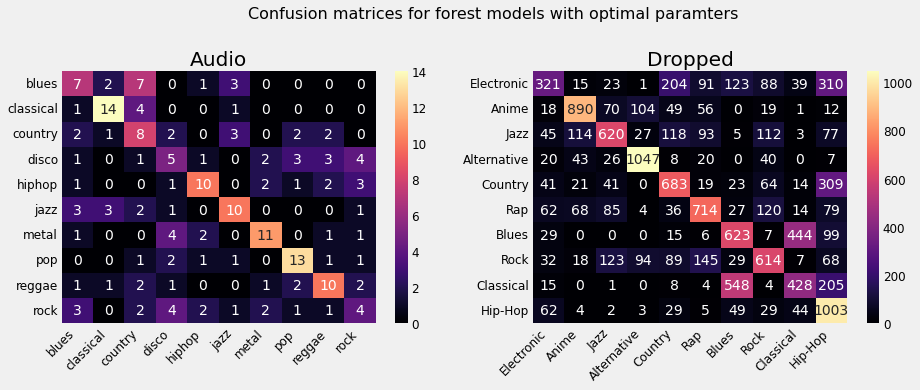

In [122]:
plot_confustion_matrices(
    [y_pred_forest_audio, y_pred_forest_dropped], [y_audio_test, y_dropped_test], 'forest')


#### Learning Curves


In [123]:
def plot_learning_curve(model, X, y, title=None, plot_name=None, splits=15):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True)
    train_sizes = np.linspace(0.05, 0.8, splits)
    train_sizes, train_mse, test_mse = learning_curve(model, X, y,
                                                      train_sizes=train_sizes,
                                                      scoring='neg_root_mean_squared_error',
                                                      cv=5, shuffle=True)

    train_scores = np.sqrt(np.abs(train_mse))
    test_scores = np.sqrt(np.abs(test_mse))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.set_title(f'test split size', fontsize=14)
    ax.plot(train_sizes, train_scores_mean, 'o-',
            color="r", label="Training score", linewidth=1, markersize=2)
    ax.plot(train_sizes, test_scores_mean, 'o-',
            color="b", label="Cross-validation score", linewidth=1, markersize=2)
    ax.set_xlabel("Training set size", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.legend(loc="best", fontsize=12)

    fig.suptitle(title, fontsize=16)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curve_' + plot_name + '.png'))

In [124]:
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
def plot_learning_curves(model, X, y, title=None, splits=[.05, .1, .15, .2, .25, .3, .35, .4], start_size=5, plot_name=None, scale=10):
    nrows = int(np.sqrt(len(splits)))
    ncols = int((len(splits) + 1) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 8), sharey=True)
    i = 0
    X_scaled = X.copy()
    sc.fit(X,y)
    X_scaled = sc.transform(X_scaled)
    miny = 10
    for split in splits:
        if nrows == 1:
            idx = i
        else:
            idx = (int(i / ncols), int(i % ncols))

        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y, test_size=split)
        train_errors, val_errors, xs = [], [], []

        for m in range(start_size, len(X_train), scale):
            model.fit(X_train[:m], y_train[:m])
            y_train_predict = model.predict(X_train[:m])
            y_val_predict = model.predict(X_val)
            train_errors.append(mean_squared_error(
                y_train[:m], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))
            xs.append(m)
        
        axs[idx].set_title(f'test split size: {split}', fontsize=14)
        axs[idx].plot(xs, np.sqrt(train_errors), 'r--.',
                      linewidth=0.5, label="train", markersize=3)
        axs[idx].plot(xs, np.sqrt(val_errors), "b-", linewidth=2, label="test")
        axs[idx].legend(loc="upper right", fontsize=12)
        axs[idx].set_xlabel("Training set size", fontsize=12)
        axs[idx].set_ylabel("RMSE", fontsize=12)
        miny = min(min([train_errors.pop(0)]), miny)
        axs[idx].set_xlim(xs[0], xs[-1])
        i += 1
        
    axs[idx].set_ylim(np.sqrt(miny), max(np.sqrt(val_errors)))
        
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.4)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curves_' + plot_name + '.png'))


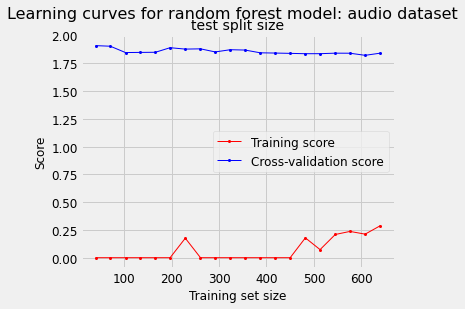

In [127]:
# plot_learning_curves(forest_audio, X_audio, y_audio_nums,
#                      'Learning curves for random forest model: audio dataset', plot_name='forest_audio')

plot_learning_curve(forest_audio, X_audio, y_audio_nums,
                    'Learning curves for random forest model: audio dataset', plot_name='forest_audio', splits=20)


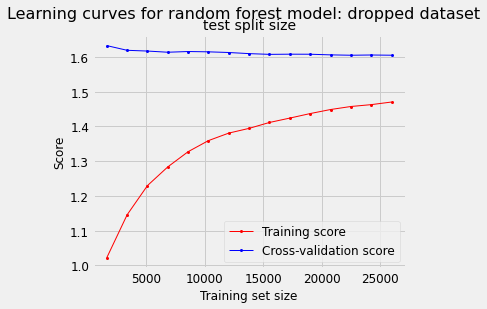

In [128]:
# plot_learning_curves(forest_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for random forest model: dropped dataset', plot_name='forest_dropped', scale=4000)

plot_learning_curve(forest_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for random forest model: dropped dataset', plot_name = 'forest_dropped')
